# Árvore de decisao e floresta aleatória - Classificação de sobrevivência no Titanic

**Grupo: Juan Felipe Serafim dos Santos (jfss) e Rodrigo Rossiter Guimarães Filho (rrgf)**

## Objetivo

Este é um mini-projeto focado na implementação e experimentação de uma árvore de decisao e floresta aleatória para a classificação da sobrevivência de passageiros do Titanic. O objetivo principal é aplicar técnicas de aprendizado de máquina para prever se uma pessoa sobreviveria ou não ao desastre do Titanic com base em atributos como idade, sexo, classe da cabine, etc.

## Dicionário das colunas para conferencia

- Parch: Quantidade de pais / crianças a bordo
- Fare (Tarifa)
- Pclass (Classe)
- Age (Idade)
- Cabin (Cabine)
- Survived (Sobreviveu)
- Sibsp: Quantidade de irmãos / cônjuges a bordo
- Ticket (Bilhete)
- Embarked (Embarque)
- Sex (Sexo)

## Projeto

### Conectando o google colab ao drive

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando bibliotecas e dados

In [117]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay,roc_curve, roc_auc_score
from matplotlib import rcParams

rcParams['figure.figsize'] = 10, 8

### Importando os dados e tratando eles



In [134]:
# Importando os dados presentes no drive
df = pd.read_csv('/content/drive/MyDrive/SI/AD/train.csv')

In [135]:
# Descartando colunas irrelevantes
df.drop(columns=['PassengerId', 'Ticket', 'Cabin'], inplace=True)

# Preencher valores faltantes na coluna 'Age' com a média das idades
df['Age'].fillna(df['Age'].mean(), inplace=True)

# Mapeando Sex para valores numéricos
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Extrair o título dos nomes
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Mapear títulos menos comuns para uma categoria 'Rare'
df['Title'] = df['Title'].replace(['Master', 'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Rare')

# Mapear títulos para categorias numéricas
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Rare": 4}
df['Title'] = df['Title'].map(title_mapping)

# Remover a coluna 'Name' original
df.drop(['Name'], axis=1, inplace=True)

# Preencher valores faltantes na coluna 'Embarked' com o valor mais frequente
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Converter a coluna 'Embarked' em variáveis dummy
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, embarked_dummies], axis=1)
df.drop(['Embarked'], axis=1, inplace=True)

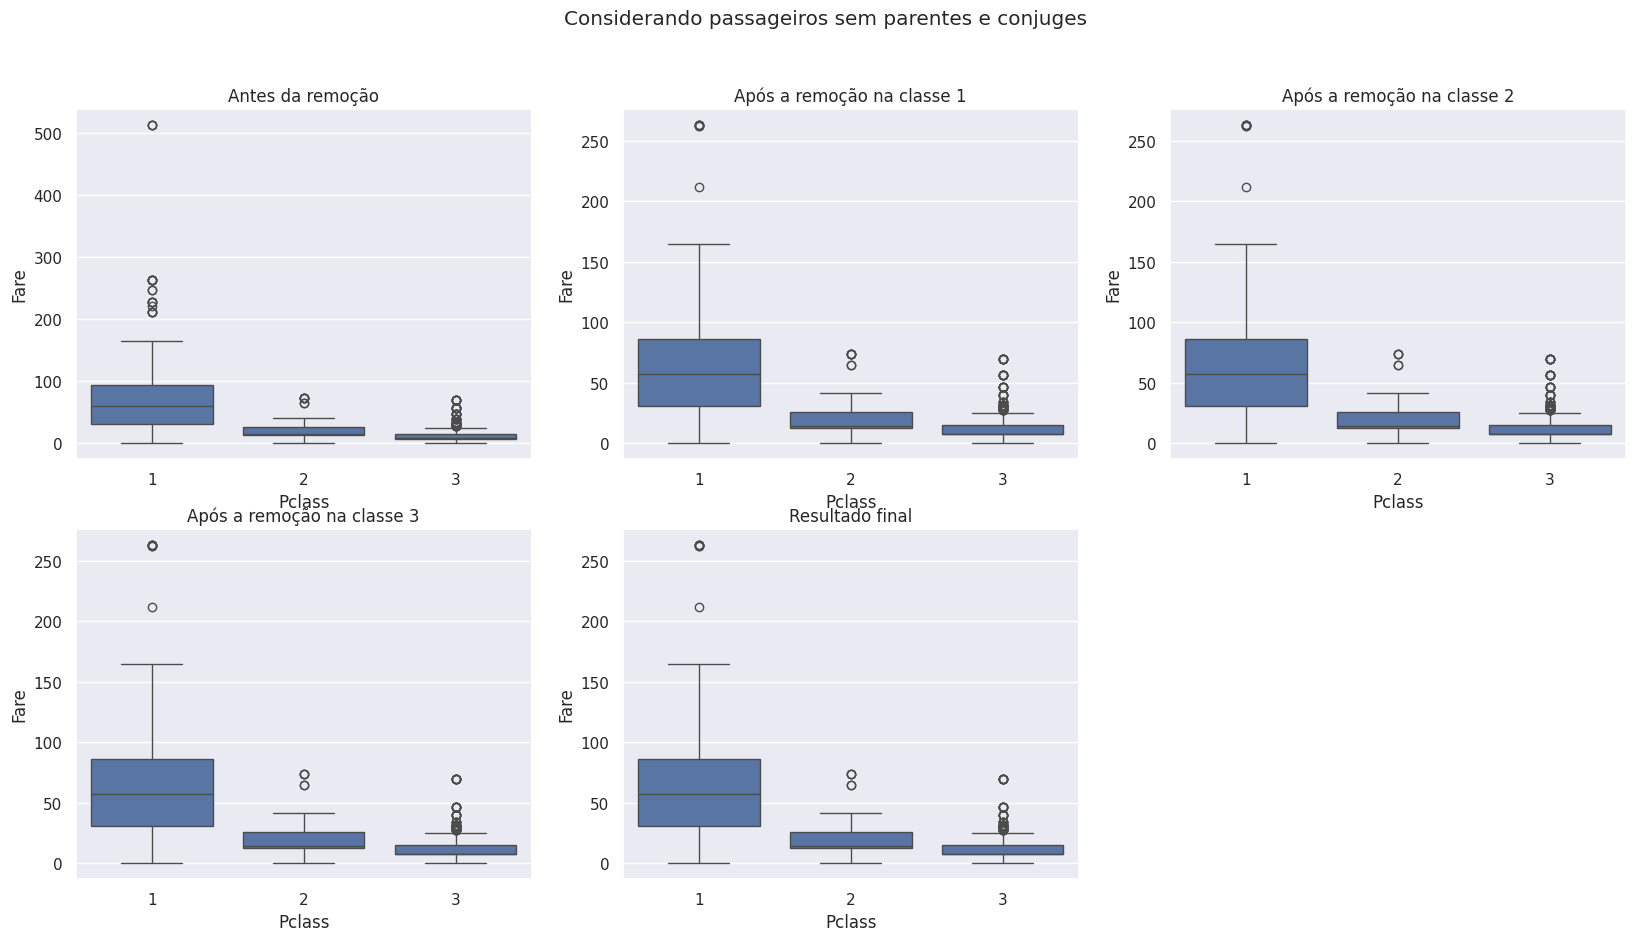

In [136]:
fig,axes = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle("Considerando passageiros sem parentes e conjuges")
axes[0,0].set_title("Antes da remoção")
sns.boxplot(data = df, x = 'Pclass', y = 'Fare',ax=axes[0,0])

#Retirando linhas onde passageiros pagaram valor de passagem exagerados mesmo vindo sozinhos ou com no máximo um vínculo
      #CLASSE 1
df.drop(df[ (df['Fare']>200) & (df['Pclass']==1) & (df['SibSp']<=1) & (df['Parch']<=1) ].index,inplace=True)
axes[0,1].set_title("Após a remoção na classe 1")
sns.boxplot(data = df, x = 'Pclass', y = 'Fare',ax=axes[0,1])
      #CLASSE 2
df.drop(df[ (df['Fare']>50) & (df['Pclass']==2) & (df['SibSp']<=1) & (df['Parch']<=1) ].index,inplace=True)
axes[0,2].set_title("Após a remoção na classe 2")
sns.boxplot(data = df, x = 'Pclass', y = 'Fare',ax=axes[0,2])
      #CLASSE 3
df.drop(df[ (df['Fare']>25) & (df['Pclass']==3) & (df['SibSp']<=1) & (df['Parch']<=1) ].index,inplace=True)
axes[1,0].set_title("Após a remoção na classe 3")
sns.boxplot(data = df, x = 'Pclass', y = 'Fare',ax=axes[1,0])


#Resultado final
axes[1,1].set_title("Resultado final")
sns.boxplot(data = df, x = 'Pclass', y = 'Fare',ax=axes[1,1])

axes[1,2].set_visible(False)
#print(df[ (df['Fare']>50) & (df['Pclass']==2) & (df['SibSp']==0) ])

Ainda existem outliers acima, mas estamos considerando que as pessoas tenham ido com crianças e/ou conjuges, o que fez com que uma delas tenha pago todas as entradas dos acompanhantes.

### Estrutura dos dados

In [137]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,1.0,0,0,1
1,1,1,1,38.0,1,0,71.2833,3.0,1,0,0
2,1,3,1,26.0,0,0,7.9250,2.0,0,0,1
3,1,1,1,35.0,1,0,53.1000,3.0,0,0,1
4,0,3,0,35.0,0,0,8.0500,1.0,0,0,1


### Separando features e target

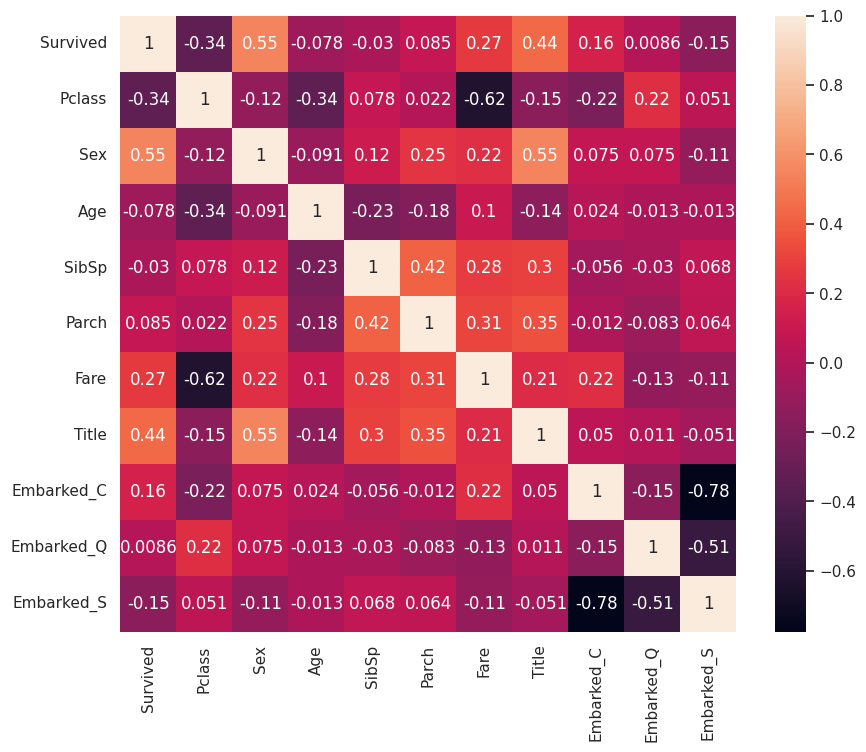

In [138]:
#Verificação de correlação entre colunas
sns.set(font_scale=1)
sns.heatmap(df.corr(), cbar=True, annot=True, square=True)

#Separação das features e target
X = df.drop(columns=['Survived'])
y = df['Survived']

De acordo com a informação de correlação entre as colunas da tabela, existe uma correlação mediana entre a classe social, preço da passagem e o título do passageiro, o que era de se esperar e que não é tão alto a ponto de atrapalhar o treinamento dos modelos.

### Dividindo o conjunto de teste e treinamento

In [139]:
# Divisão do conjunto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Preenchendo valores ausentes


In [140]:
# Imputer para preencher os valores ausentes com a média
imputer = SimpleImputer(strategy='mean')

# Aplicar o imputer aos dados de treino
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

### Criação e treinamentos do modelos

In [141]:
# Treinar e avaliar modelo de Árvore de Decisão
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_imputed, y_train)
dt_pred = dt_classifier.predict(X_test_imputed)

In [142]:
# Treinar e avaliar modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_imputed, y_train)
rf_pred = rf_classifier.predict(X_test_imputed)

### Visualização e avaliação do modelo

#### Decision Tree

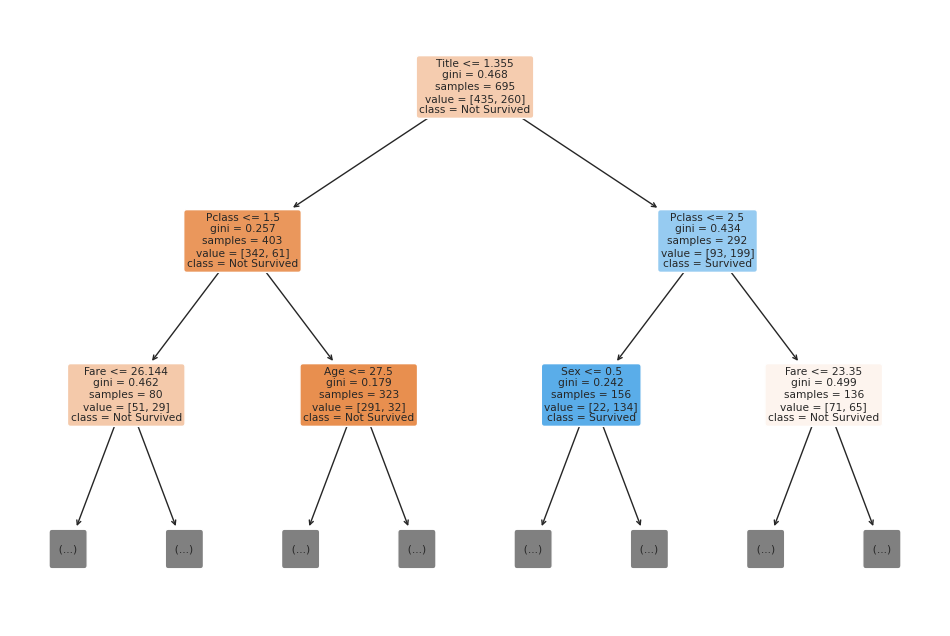

In [143]:
# Plotando a decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Not Survived", "Survived"], filled=True, rounded=True, max_depth=2)
plt.show()

In [144]:
# Resultados
print(classification_report(y_test, dt_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8200    0.7664    0.7923       107
           1     0.6622    0.7313    0.6950        67

    accuracy                         0.7529       174
   macro avg     0.7411    0.7488    0.7437       174
weighted avg     0.7592    0.7529    0.7548       174



#### Random Forest

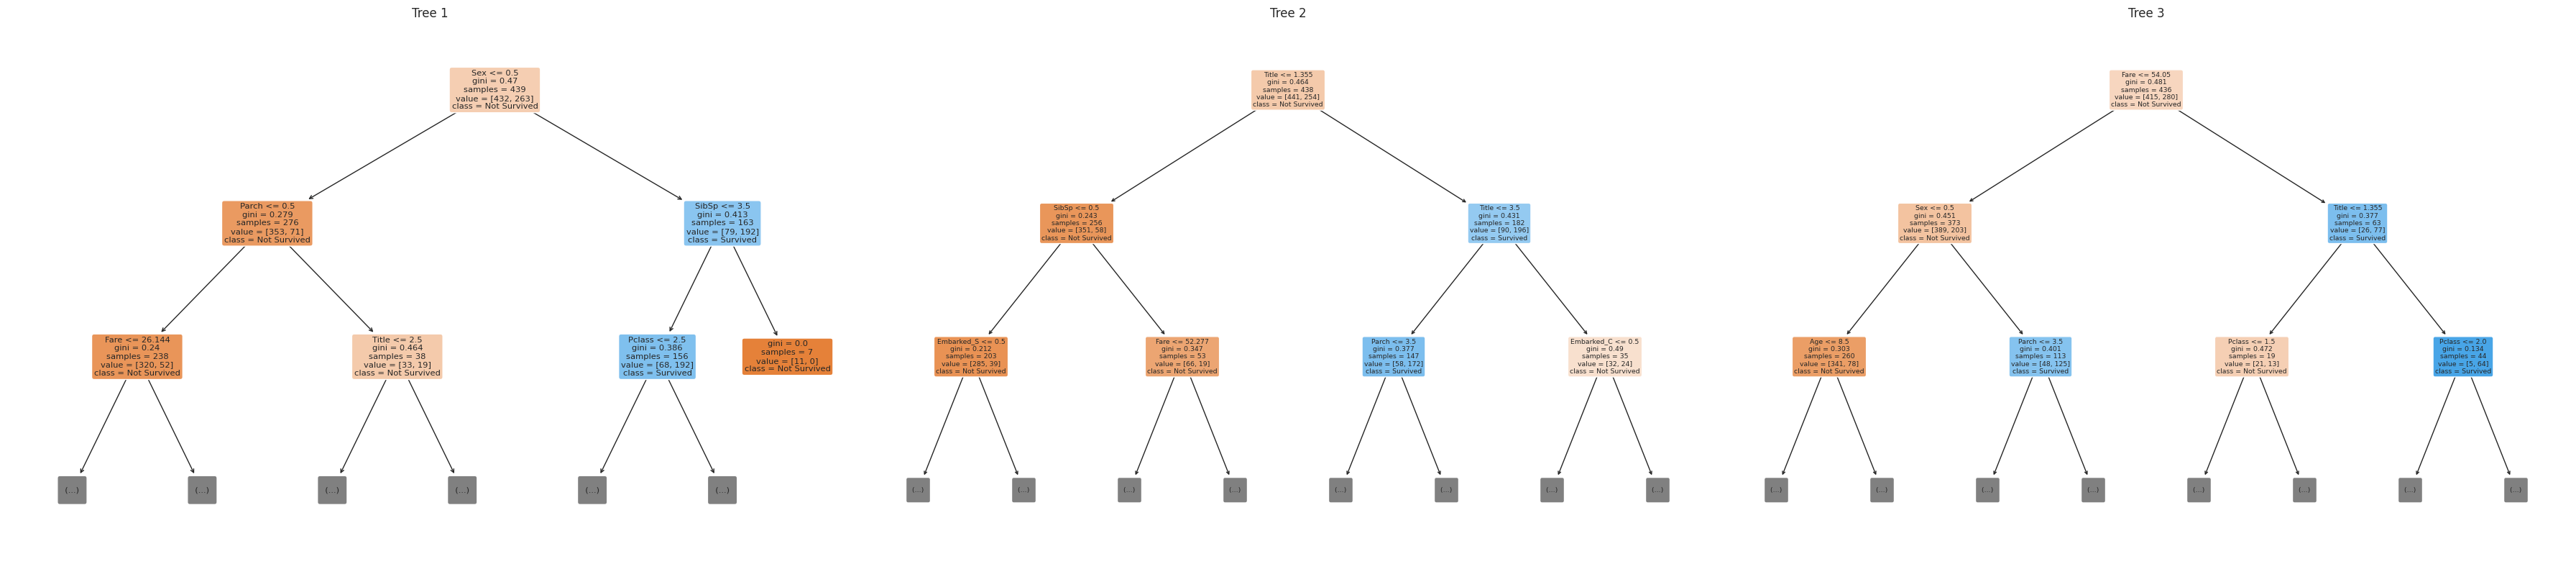

In [145]:
tree_num = 3
fig, axes = plt.subplots(nrows=1, ncols=tree_num, figsize=(tree_num*12, 8))

# Iterar sobre as árvores e plotá-las
for i in range(tree_num):
  tree = rf_classifier.estimators_[i]
  ax = axes[i] if tree_num > 1 else axes
  plot_tree(tree, feature_names=X.columns, class_names=["Not Survived", "Survived"], ax=ax, filled=True, rounded=True, max_depth=2)
  ax.set_title(f'Tree {i+1}')

plt.tight_layout()
plt.show()

In [146]:
print(classification_report(y_test, rf_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9010    0.8505    0.8750       107
           1     0.7808    0.8507    0.8143        67

    accuracy                         0.8506       174
   macro avg     0.8409    0.8506    0.8446       174
weighted avg     0.8547    0.8506    0.8516       174



### Matrizes de confusão

In [131]:
def plot_confusion_matrix(cm,ax):
  group_names = ['True Dead', 'False Alive', 'False Dead', 'True Alive']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2, 2)
  sns.set(font_scale=1)
  sns.heatmap(cm, annot=labels, fmt='', cmap='coolwarm',ax=ax)

#### Decision Tree

Text(0.5, 1.0, 'Matriz de Confusão - Decision Tree')

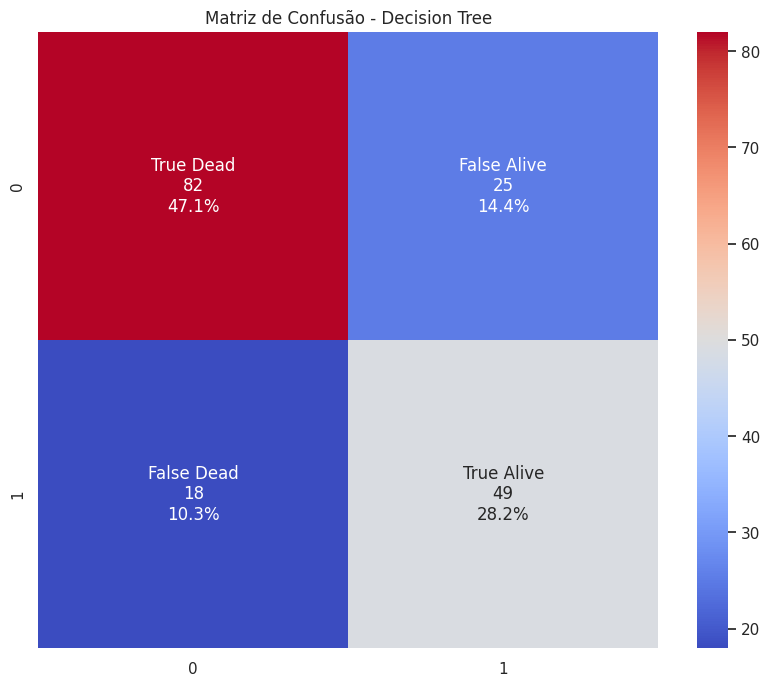

In [147]:
# Matriz de confusão para Árvore de Decisão
dt_cm = confusion_matrix(y_test, dt_pred)
plot_confusion_matrix(dt_cm, ax=plt.subplot())
plt.title('Matriz de Confusão - Decision Tree')


#### Random Forest

Text(0.5, 1.0, 'Matriz de Confusão - Random Forest')

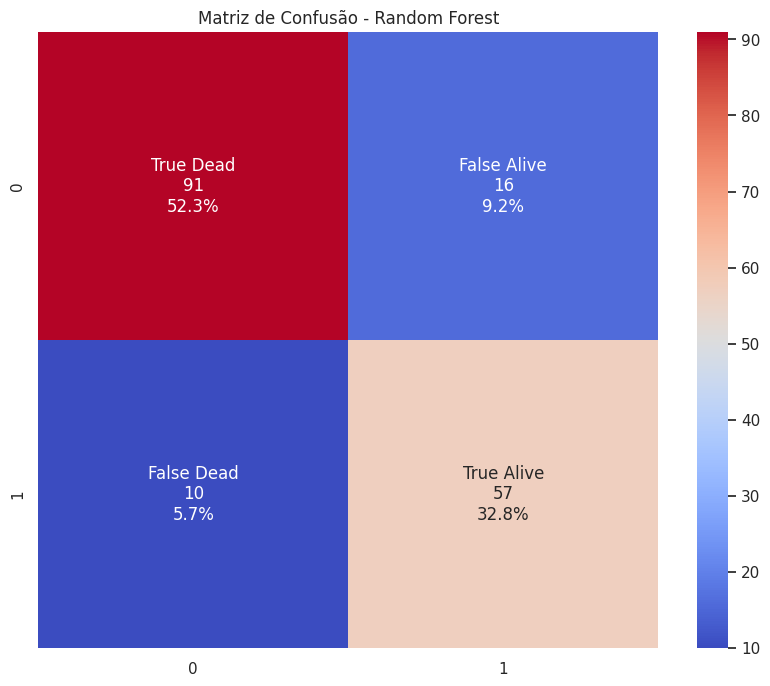

In [148]:
# Matriz de confusão para Random Forest
rf_cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(rf_cm, ax=plt.subplot())
plt.title('Matriz de Confusão - Random Forest')